In [1]:
!nvidia-smi

Sat Sep  4 19:18:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


# Data Preprocessing


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [5]:
%cd '/content/drive/MyDrive/RNNs'

/content/drive/MyDrive/RNNs


In [6]:
!ls

RSCCASN.csv  RSCSSN.ipynb


In [7]:
#reading plus converting string date column as timestamps and making it index
df = pd.read_csv('RSCCASN.csv' , parse_dates=True , index_col='DATE')

In [8]:
df

RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558
...             ...
2019-06-01    21123
2019-07-01    21714
2019-08-01    23791
2019-09-01    19695
2019-10-01    21113

[334 rows x 1 columns]

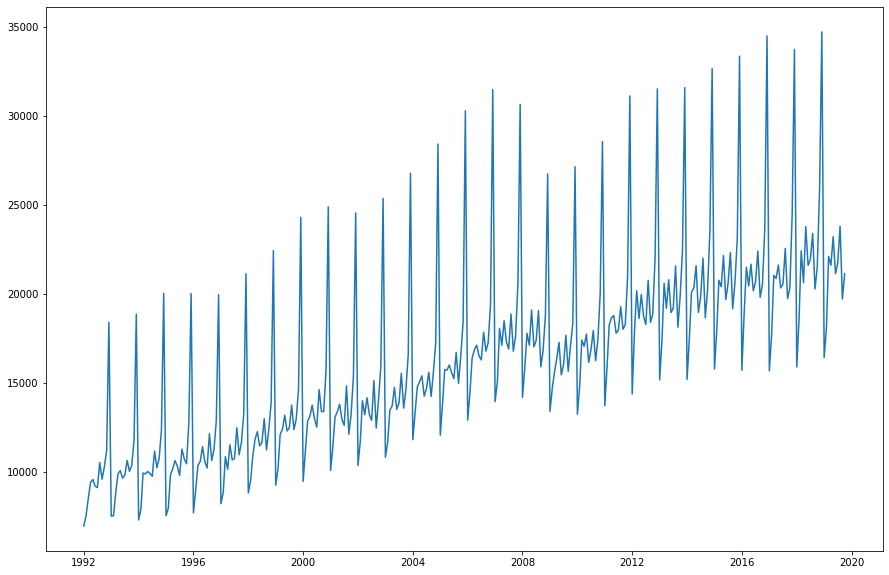

In [9]:
plt.figure(figsize=(15,10))
plt.plot(df)

## Splitting 

In [10]:
#we Choose the splitting to be 1.5 years as there is one complete pattern in one year(thats all info we need)
#Data frame is divided into months so 12 months units a year so 18 months 18 units
len(df) - 18

316

In [11]:
train  = df.iloc[:316]

In [12]:
test = df.iloc[316 :]

In [13]:
len(test)
len(train)

316

## Scaling

In [14]:
 from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)
train_scaler = scaler.transform(train)
test_scaler = scaler.transform(test)

In [17]:
full_scaled_df = scaler.transform(df)

In [18]:
test_scaler

array([[0.61087714],
       [0.53191258],
       [0.54389341],
       [0.59697212],
       [0.4836625 ],
       [0.52770113],
       [0.68592071],
       [1.00813244],
       [0.34388615],
       [0.40647691],
       [0.55021057],
       [0.53220302],
       [0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

## Creating Batches 

In [19]:
import tensorflow
import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
#our one full pattern is completing in 12 months so length is 12
length = 12
batchsize=  1    #we need one forcast per iter
 
train_generator =  TimeseriesGenerator(data = train_scaler , targets= train_scaler , length = length , batch_size=batchsize)
test_generator =  TimeseriesGenerator(data = test_scaler ,targets = test_scaler ,  length = length , batch_size=batchsize)



In [21]:
test_generator[0]

(array([[[0.61087714],
         [0.53191258],
         [0.54389341],
         [0.59697212],
         [0.4836625 ],
         [0.52770113],
         [0.68592071],
         [1.00813244],
         [0.34388615],
         [0.40647691],
         [0.55021057],
         [0.53220302]]]), array([[0.59040081]]))

# Train

## Early Stoppings

In [22]:
from tensorflow.keras.callbacks import  EarlyStopping

In [23]:
earlystop  = EarlyStopping(monitor='val_loss' ,patience=2  )


## Train Config

In [24]:
from tensorflow.keras.layers import Dense , LSTM
from tensorflow.keras.models import Sequential


In [25]:
#we are predicitng from one feature so n_feature = 1
n_features = 1

In [47]:
model  = Sequential()
model.add(LSTM(units = 128 ,activation='relu' , input_shape = (length,n_features)))
#output layer
model.add(Dense(units = 1  ))



In [48]:
model.compile(optimizer='adam'  , loss='mse')

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit_generator(train_generator , validation_data= test_generator , callbacks= [earlystop], epochs = 20)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 11s 32ms/step - loss: 0.0243 - val_loss: 0.0029
Epoch 2/20
304/304 [==============================] - 9s 31ms/step - loss: 0.0153 - val_loss: 0.0031
Epoch 3/20
304/304 [==============================] - 9s 31ms/step - loss: 0.0076 - val_loss: 0.0018
Epoch 4/20
304/304 [==============================] - 9s 30ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 5/20
304/304 [==============================] - 10s 33ms/step - loss: 0.0016 - val_loss: 3.2848e-04
Epoch 6/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/20
304/304 [==============================] - 9s 31ms/step - loss: 0.0022 - val_loss: 8.1532e-04


In [51]:
loss  = pd.DataFrame(model.history.history)
loss

loss  val_loss
0  0.024311  0.002905
1  0.015263  0.003122
2  0.007627  0.001789
3  0.004255  0.004893
4  0.001640  0.000328
5  0.001935  0.001720
6  0.002244  0.000815

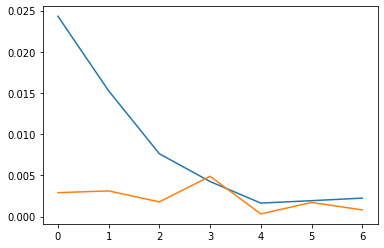

In [53]:
plt.plot(loss)

# Test

**Important MAKING PREDICTIONS**

In [54]:
test_predictions  = []

#take last no of lenght (18) values from train-scaled to forecast future
first_eval_batch = train_scaler[-length:]
#reshape it in form in which we trained our data input shape
current_batch = first_eval_batch.reshape((1,length,n_features))

#creating loop which predicts future values then from array delete last value
#append the predicted value at top and run for no of instances in test data
#wil run for 18 values
for i in range(len(test)):
  #getting prediction on current batch
  current_pred = model.predict(current_batch)[0]
  #appending predictions in array
  test_predictions.append(current_pred)

  #remove last length dimension value form batch anda add predictins at the top
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1  )





In [55]:
#has now predicted values in future from last 18 values of scaled_trian
test_predictions

[array([0.54126304], dtype=float32),
 array([0.5000268], dtype=float32),
 array([0.5084426], dtype=float32),
 array([0.5760861], dtype=float32),
 array([0.4846701], dtype=float32),
 array([0.50619173], dtype=float32),
 array([0.6537468], dtype=float32),
 array([1.0565597], dtype=float32),
 array([0.35947847], dtype=float32),
 array([0.44054878], dtype=float32),
 array([0.5668528], dtype=float32),
 array([0.5081986], dtype=float32),
 array([0.5512521], dtype=float32),
 array([0.5147925], dtype=float32),
 array([0.52414536], dtype=float32),
 array([0.58811396], dtype=float32),
 array([0.50575507], dtype=float32),
 array([0.52823794], dtype=float32)]

**Inverse from scaled form to be compred to original test values**

In [56]:
true_pred = scaler.inverse_transform(test_predictions)

In [57]:
true_pred

array([[21967.79220247],
       [20822.7447958 ],
       [21056.43358088],
       [22934.75893354],
       [20396.31940889],
       [20993.9319725 ],
       [25091.24069071],
       [36276.54924679],
       [16919.99825668],
       [19171.15845585],
       [22678.36877251],
       [21049.65924931],
       [22245.16905403],
       [21232.75819349],
       [21492.46848869],
       [23268.74854136],
       [20981.80669689],
       [21606.11108685]])

In [58]:
test

RSCCASN   predictions
DATE                             
2018-05-01    23764  23384.059962
2018-06-01    21589  22228.587867
2018-07-01    21919  22582.079699
2018-08-01    23381  24764.576626
2018-09-01    20260  21881.996312
2018-10-01    21473  22714.143738
2018-11-01    25831  27524.135663
2018-12-01    34706  40623.091904
2019-01-01    16410  18123.211381
2019-02-01    18134  20560.955338
2019-03-01    22093  24442.939676
2019-04-01    21597  22956.892942
2019-05-01    23200  26112.369923
2019-06-01    21123  25069.390561
2019-07-01    21714  25690.817689
2019-08-01    23791  28465.717240
2019-09-01    19695  25145.592402
2019-10-01    21113  26472.036377

In [59]:
#converging real and predicted in single dataframe in test
test['predictions'] = true_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


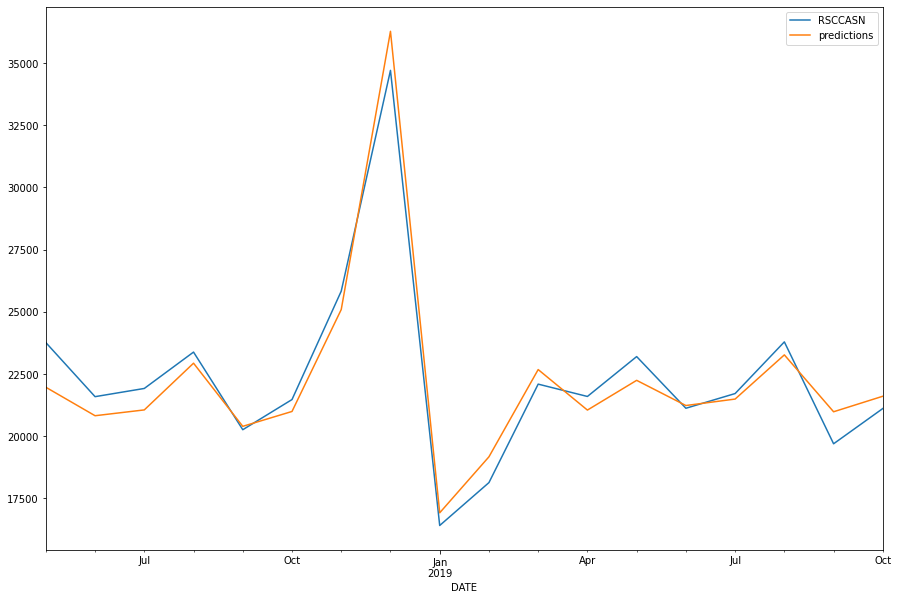

In [60]:
test.plot(figsize =(15,10) )

# Future Trends Predictions

**Retrain on full scaled dataframe**

In [61]:
#creating full scaled dataframe
full_scaled = scaler.fit_transform(df)

In [62]:
#generating time series

full_generator = TimeseriesGenerator(full_scaled,full_scaled,length=length,batch_size=1)

In [64]:
model  = Sequential()
model.add(LSTM(units = 128 ,activation='relu' , input_shape = (length,n_features)))
#output layer
model.add(Dense(units = 1  ))


model.compile(optimizer='adam'  , loss='mse')

In [65]:
model.fit_generator(full_generator  , epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
322/322 [==============================] - 11s 30ms/step - loss: 0.0244
Epoch 2/10
322/322 [==============================] - 10s 30ms/step - loss: 0.0169
Epoch 3/10
322/322 [==============================] - 10s 30ms/step - loss: 0.0090
Epoch 4/10
322/322 [==============================] - 10s 32ms/step - loss: 0.0039
Epoch 5/10
322/322 [==============================] - 10s 30ms/step - loss: 0.0028
Epoch 6/10
322/322 [==============================] - 10s 31ms/step - loss: 0.0017
Epoch 7/10
322/322 [==============================] - 10s 30ms/step - loss: 0.0013
Epoch 8/10
322/322 [==============================] - 10s 31ms/step - loss: 0.0013
Epoch 9/10
322/322 [==============================] - 10s 31ms/step - loss: 0.0016
Epoch 10/10
322/322 [==============================] - 10s 31ms/step - loss: 0.0013


In [66]:
#Future Predictions making

forecasting  = []

#take last no of lenght (18) values from train-scaled to forecast future
first_eval_batch = train_scaler[-length:]
#reshape it in form in which we trained our data input shape
current_batch = first_eval_batch.reshape((1,length,n_features))

#creating loop which predicts future values then from array delete last value
#append the predicted value at top and run for no of instances in test data
#wil run for 18 values
for i in range(12):
  #getting prediction on current batch
  current_pred = model.predict(current_batch)[0]
  #appending predictions in array
  forecasting.append(current_pred)

  #remove last length dimension value form batch anda add predictins at the top
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1  )





In [67]:
#inverse
true_pred_full = scaler.inverse_transform(forecasting)

In [68]:
true_pred_full

array([[21706.75782585],
       [20610.00215125],
       [20835.59831619],
       [22589.12071943],
       [20143.85018396],
       [20758.00052452],
       [24460.74290991],
       [33483.28197718],
       [16597.3551991 ],
       [19132.21970391],
       [22401.84098816],
       [20829.41651106]])

In [69]:
df

RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558
...             ...
2019-06-01    21123
2019-07-01    21714
2019-08-01    23791
2019-09-01    19695
2019-10-01    21113

[334 rows x 1 columns]

In [70]:
#INdex Generator
forecast_index = pd.date_range(start='2019-11-1', periods=12, freq='MS')

In [71]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [72]:
#appending forecast_index and forecast in one df
forecasteddata  = pd.DataFrame( true_pred_full ,index = forecast_index , columns=['Forecast'])

In [73]:
forecasteddata

Forecast
2019-11-01  21706.757826
2019-12-01  20610.002151
2020-01-01  20835.598316
2020-02-01  22589.120719
2020-03-01  20143.850184
2020-04-01  20758.000525
2020-05-01  24460.742910
2020-06-01  33483.281977
2020-07-01  16597.355199
2020-08-01  19132.219704
2020-09-01  22401.840988
2020-10-01  20829.416511

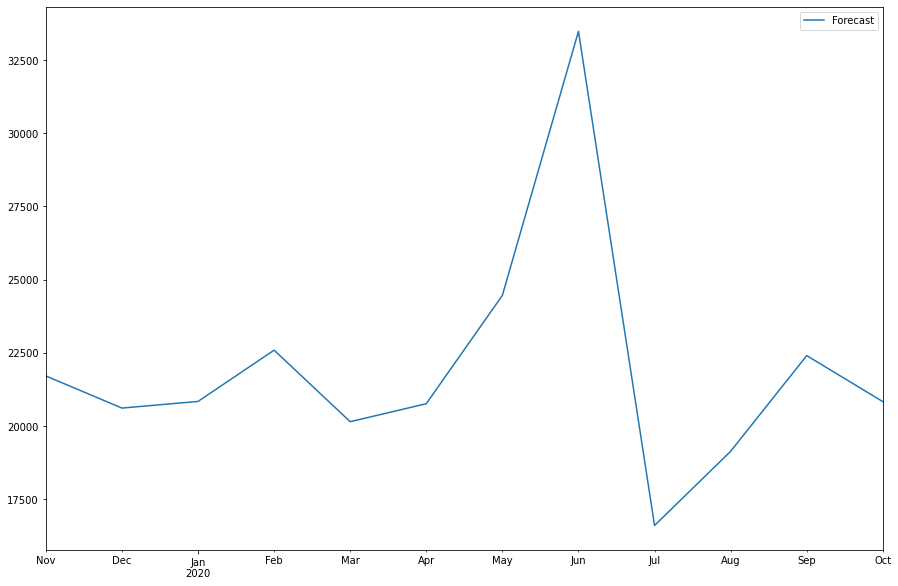

In [74]:
forecasteddata.plot(figsize = (15,10))

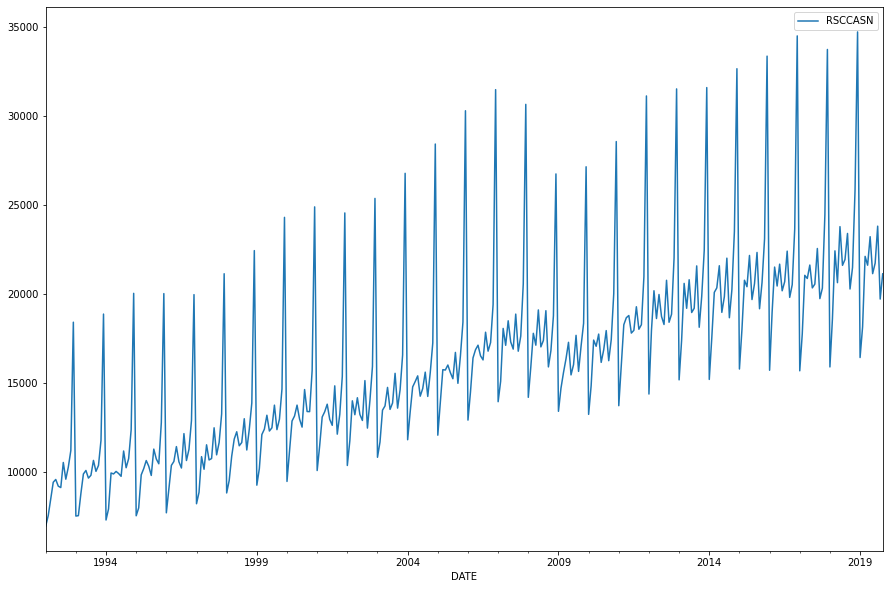

In [75]:
df.plot(figsize = (15,10))


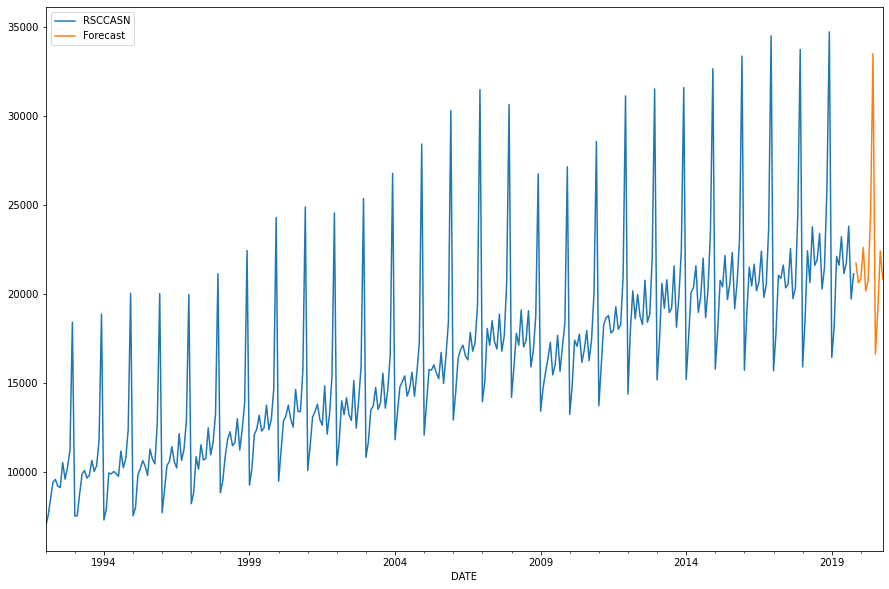

In [77]:
ax = df.plot()
forecasteddata.plot(ax = ax , figsize = (15,10))